# Structural Estimation HW3

## Takuya Ando

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.stats as sts
import math
import scipy.special as spc
import numpy.linalg as lin
import scipy.integrate as intgr

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Question1

(a) Load data.

In [38]:
inc = pd.read_csv("data/hh_inc_synth.txt", header=None)
inc = inc[0]

First we construct the bin bounds with width of 5000 dollars(The last two bounds are 250000 and 350000). Then using the bin bounds, counts of observations in each bin can be calculated. We can divide each counts with number of observation to compute the percent of observation.(moments) The resulting moments are as below. 

In [39]:
bin_edge = np.append(np.arange(0, 205000, 5000), np.array([250000, 350000]))
hist, edges = np.histogram(inc, bins=bin_edge)
hist/len(inc)

array([0.03519016, 0.04106206, 0.05885948, 0.05683611, 0.0585952 ,
       0.05443284, 0.05506049, 0.05067515, 0.04785894, 0.04083908,
       0.04269728, 0.03509931, 0.03660239, 0.03168022, 0.02978073,
       0.0285089 , 0.0250733 , 0.02119172, 0.02142297, 0.01859025,
       0.02086964, 0.01462609, 0.01422967, 0.01295784, 0.01271834,
       0.0103894 , 0.01000124, 0.00758145, 0.00851468, 0.00737498,
       0.0096296 , 0.00611141, 0.00575629, 0.00503778, 0.00509559,
       0.00437709, 0.00379898, 0.00299789, 0.00313829, 0.0025767 ,
       0.01897014, 0.02319032])

(b)We plot the histogram using the bin bounds calculated above. As the unit of income is in thousands, we also set the width of each bin as 5, not 5000 here. The resulting histogram is as below.

(0, 0.015)

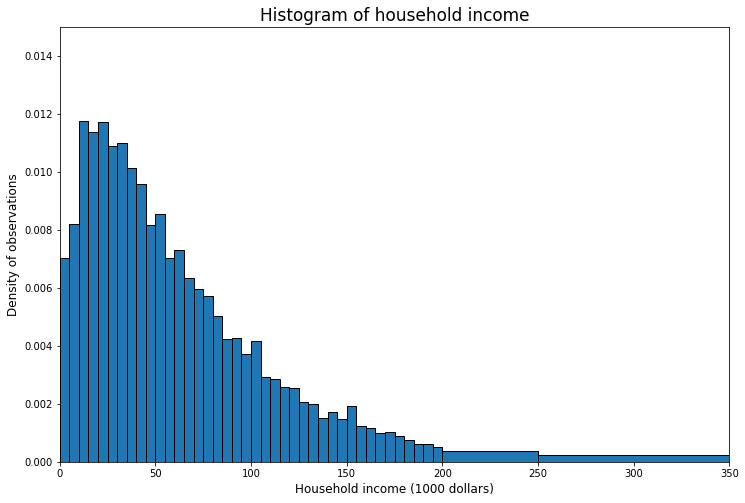

In [40]:
plt.figure(figsize=(12, 8))

weights = (1 / (inc.shape[0]*5)) * np.ones_like(inc)

weights[(len(weights) - (hist[-2] + hist[-1]) +1) : (len(weights) - hist[-1] +1)] =\
weights[(len(weights) - (hist[-2] + hist[-1]) +1) : (len(weights) - hist[-1] +1)]/10

weights[(len(weights) - hist[-1] +1) :] =\
weights[(len(weights) - hist[-1] +1) :]/20

inc_sort = np.sort(inc)

x_scale = np.array([0, 50000, 100000, 150000, 200000, 250000, 300000, 350000])

plt.hist(inc_sort, bins=edges, weights=weights, edgecolor="k")
plt.title('Histogram of household income', fontsize=17)
plt.xlabel(r'Household income (1000 dollars)', fontsize=12)
plt.xticks(x_scale, (x_scale/1000).astype(int))
plt.ylabel(r'Density of observations', fontsize=12)
plt.xlim([0, 350000])
plt.ylim([0, 0.015])

(b)We plot the histogram using the bin bounds calculated above. As the unit of income is in thousands, we also set the width of each bin as 5, not 5000 here. The resulting histogram is as below.

In [41]:
def model_moments_1c(mu, sigma, bin_bound_list):
    bins = len(bin_bound_list)
    model_moments = np.zeros(bins)
    for bin_ind in range(bins):
        if bin_ind == 0:
            model_moments[bin_ind] = \
                sts.lognorm.cdf(bin_bound_list[bin_ind], s=sigma,
                                scale=np.exp(mu))
        elif bin_ind > 0 and bin_ind < bins - 1:
            model_moments[bin_ind] = \
                (sts.lognorm.cdf(bin_bound_list[bin_ind], s=sigma,
                                 scale=np.exp(mu)) -
                 sts.lognorm.cdf(bin_bound_list[bin_ind - 1], s=sigma,
                                 scale=np.exp(mu)))
        elif bin_ind == bins - 1:
            model_moments[bin_ind] = \
                (1 - sts.lognorm.cdf(bin_bound_list[bin_ind - 1],
                                     s=sigma, scale=np.exp(mu)))

    return model_moments

(c)Define pdf function for log_normal distribution.

In [42]:
def log_norm_pdf(xvals, mu, sigma):
            
    pdf_vals = (1/ (xvals*sigma* np.sqrt(2*np.pi)))*\
    np.exp(-((np.log(xvals)-mu)**2)/(2*sigma**2))
    
    return pdf_vals

Then, we also define functions for data moments, model moments, error vector and criterion function.

In [43]:
def data_moments(xvals):
    '''
    This function computes data moments for GMM
    (percent of obsevation for each bin). as well as each bin bound
    '''
    bin_edge = np.append(np.arange(0, 205000, 5000), np.array([250000, 350000]))
    hist, edges = np.histogram(xvals, bins=bin_edge)
    pct_datas = hist/ len(xvals)
    
    return pct_datas, edges[1:]

def model_moments_1c(mu, sigma, bin_bound_list):
    bins = len(bin_bound_list)
    model_moments = np.zeros(bins)
    for bin_ind in range(bins):
        if bin_ind == 0:
            model_moments[bin_ind] = \
                sts.lognorm.cdf(bin_bound_list[bin_ind], s=sigma,
                                scale=np.exp(mu))
        elif bin_ind > 0 and bin_ind < bins - 1:
            model_moments[bin_ind] = \
                (sts.lognorm.cdf(bin_bound_list[bin_ind], s=sigma,
                                 scale=np.exp(mu)) -
                 sts.lognorm.cdf(bin_bound_list[bin_ind - 1], s=sigma,
                                 scale=np.exp(mu)))
        elif bin_ind == bins - 1:
            model_moments[bin_ind] = \
                (1 - sts.lognorm.cdf(bin_bound_list[bin_ind - 1],
                                     s=sigma, scale=np.exp(mu)))

    return model_moments

def err_vec(xvals, mu, sigma, simple):
    '''
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    '''
    moms_data, bin_bounds = data_moments(xvals)
    moms_model = model_moments_1c(mu, sigma, bin_bounds/1000)
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

def criterion(params, *args):
    '''
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    '''
    mu, sigma = params
    xvals, W = args
    err = err_vec(xvals, mu, sigma, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

Now we perform GMM estimation for log-normal distribution. The estimated parameters are mu=3.86 and sigma = 0.91. The minimized criterion function value is 0.046.

In [44]:
# Note that this takes a little time because the intgr.quad() commands
# are a little slow
moms_data = hist/ len(inc)
mu_init = np.log(np.mean(inc))
sig_init = np.log(np.sqrt(np.var(inc)))
params_init = np.array([mu_init, sig_init])
W_hat = np.diag(moms_data)
gmm_args = (inc, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       tol=1e-14, method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)
results

mu_GMM1= 3.859088768762434  sig_GMM1= 0.907841169197452


      fun: 0.045945281008437026
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.22044605e-08,  1.11022302e-08])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 108
      nit: 18
   status: 0
  success: True
        x: array([3.85908877, 0.90784117])

The overlayed plot of the estimated log normal distribution with GMM is as below. It seems the estimated distribution grabs the entire picture well but in the lower values the estimation is too high comparing to the actual values.

(0, 0.015)

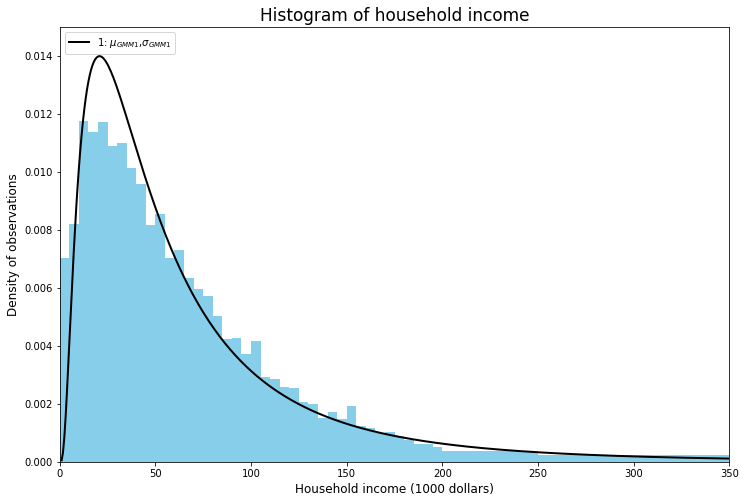

In [45]:
plt.figure(figsize=(12, 8))

weights = (1 / (inc.shape[0]*5)) * np.ones_like(inc)

weights[(len(weights) - (hist[-2] + hist[-1]) +1) : (len(weights) - hist[-1] +1)] =\
weights[(len(weights) - (hist[-2] + hist[-1]) +1) : (len(weights) - hist[-1] +1)]/10

weights[(len(weights) - hist[-1] +1) :] =\
weights[(len(weights) - hist[-1] +1) :]/20

inc_sort = np.sort(inc)

x_scale = np.array([0, 50000, 100000, 150000, 200000, 250000, 300000, 350000])

plt.hist(inc_sort, bins=edges, weights=weights, color="skyblue")

# Plot the estimated GMM PDF
dist_pts = np.linspace(1, 350, 500)
plt.plot(dist_pts*1000, log_norm_pdf(dist_pts, mu_GMM1, sig_GMM1),
         linewidth=2, color='k', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')

plt.title('Histogram of household income', fontsize=17)
plt.xlabel(r'Household income (1000 dollars)', fontsize=12)
plt.xticks(x_scale, (x_scale/1000).astype(int))
plt.ylabel(r'Density of observations', fontsize=12)
plt.xlim([0, 350000])
plt.ylim([0, 0.015])

(d) First, we define pdf and cdf functions for gamma distribution.

In [46]:
def gamma_dist(xvals, alpha, beta):
    '''
    Compute the probability density of gamma ditribution for data xvals
    given parameters alpha and beta.
    '''
    pdf_vals = ((1 / ((beta ** alpha) * spc.gamma(alpha))) *
                (xvals ** (alpha - 1)) * (np.exp(-xvals/beta)))
    return pdf_vals

def gamma_cdf(alpha,beta, lb, ub):
    pdf = lambda x: gamma_dist(x, alpha, beta)
    (bpct_1_mod, _) = intgr.quad(pdf, lb, ub)
    return bpct_1_mod

Next, similary with the previous question, we define model moments, error vector and criterion functions. 

In [47]:
def model_moments_1d(alpha, beta, bin_bound_list):
    bins = len(bin_bound_list)
    model_moments = np.zeros(bins)
    for bin_ind in range(bins):
        if bin_ind == 0:
            model_moments[bin_ind] = \
                gamma_cdf(alpha, beta, 0, bin_bound_list[bin_ind])
        elif bin_ind > 0 and bin_ind < bins - 1:
            model_moments[bin_ind] = \
                gamma_cdf(alpha, beta, bin_bound_list[bin_ind-1],
                                 bin_bound_list[bin_ind])
        elif bin_ind == bins - 1:
            model_moments[bin_ind] = \
                1 - gamma_cdf(alpha, beta, 0,
                                 bin_bound_list[bin_ind-1])

    return model_moments

def err_vec(xvals, alpha, beta, simple):
    moms_data, bin_bounds = data_moments(xvals)
    moms_model = model_moments_1d(alpha, beta, bin_bounds)
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion(params, *args):
    
    alpha, beta = params
    xvals, W = args
    err = err_vec(xvals, alpha, beta, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

Then we perform GMM estimation. The estimated parameters are alpha=1.36 and beta = 48400. The minimized criterion function value is 0.012. 

In [48]:
# Note that this takes a little time because the intgr.quad() commands
# are a little slow
moms_data = hist/ len(inc)
alpha_init = 3
beta_init = 20000
params_init = np.array([alpha_init, beta_init])
W_hat = np.diag(moms_data)
gmm_args = (inc, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       tol=1e-14, method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None)))
alpha_GMM1, beta_GMM1 = results.x
print('alpha_GMM1=', alpha_GMM1, ' beta_GMM1=', beta_GMM1)
results

alpha_GMM1= 1.3592015450583836  beta_GMM1= 48400.38315503652


      fun: 0.01234724712397501
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.20476553e-03, -4.44089210e-08])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 147
      nit: 24
   status: 0
  success: True
        x: array([1.35920155e+00, 4.84003832e+04])

The overlayed estimated histogram from gamma distribution is as below.(green line)

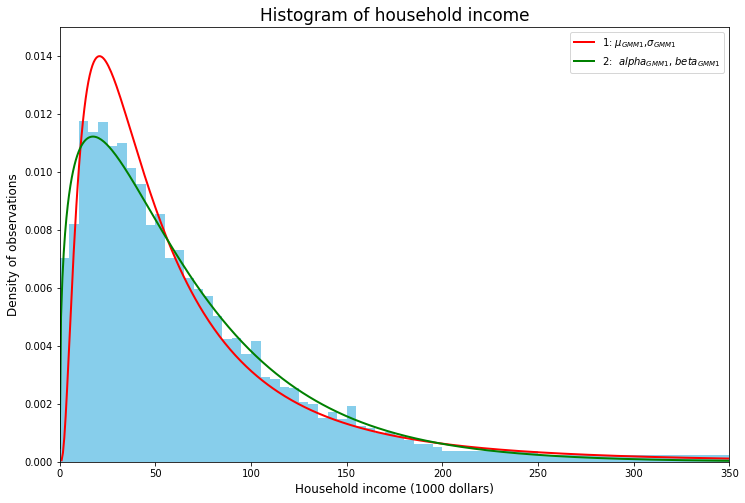

In [49]:
plt.figure(figsize=(12, 8))

weights = (1 / (inc.shape[0]*5)) * np.ones_like(inc)

weights[(len(weights) - (hist[-2] + hist[-1]) +1) : (len(weights) - hist[-1] +1)] =\
weights[(len(weights) - (hist[-2] + hist[-1]) +1) : (len(weights) - hist[-1] +1)]/10

weights[(len(weights) - hist[-1] +1) :] =\
weights[(len(weights) - hist[-1] +1) :]/20

inc_sort = np.sort(inc)

x_scale = np.array([0, 50000, 100000, 150000, 200000, 250000, 300000, 350000])

plt.hist(inc_sort, bins=edges, weights=weights, color="skyblue")

# Plot the estimated GMM PDF for log-normal
dist_pts = np.linspace(1, 350, 500)
plt.plot(dist_pts*1000, log_norm_pdf(dist_pts, mu_GMM1, sig_GMM1),
         linewidth=2, color='red', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')

# Plot the estimated GMM PDF for gamma
dist_pts = np.linspace(1, 350000, 500)
plt.plot(dist_pts, gamma_dist(dist_pts, alpha_GMM1, beta_GMM1)*1000,
         linewidth=2, color='green', label='2: $\ alpha_{GMM1}$,$\ beta_{GMM1}$')

plt.title('Histogram of household income', fontsize=17)
plt.xlabel(r'Household income (1000 dollars)', fontsize=12)
plt.xticks(x_scale, (x_scale/1000).astype(int))
plt.ylabel(r'Density of observations', fontsize=12)
plt.xlim([0, 350000])
plt.ylim([0, 0.015])
plt.legend(loc='upper right')

(e)Looking at the plot from (d), gamma distribution seems fitting better for the data especially in lower values. Also, the minimized criterion function values is smaller for gamma distribution. Thus, gamma distribution is fitting better here.

(f)First, we define the function for error matrix.

In [50]:
def data_moments(xvals):
    '''
    This function computes data moments for GMM
    (percent of obsevation for each bin). as well as each bin bound
    
    '''
    bin_edge = np.append(np.arange(0, 205000, 5000), np.array([250000, 350000]))
    hist, edges = np.histogram(xvals, bins=bin_edge)
    pct_datas = hist/ len(xvals)
    
    return pct_datas, edges[1:]

def get_Err_mat(pts, alpha, beta, bin_bound_list, simple=False):
    '''
    
    '''
    R = 42
    N = len(pts)
    Err_mat = np.zeros((R, N))
    moms_data = data_moments(pts)[0]
    moms_model = model_moments_1d(alpha, beta, bin_bound_list)
    
    if simple:
        for i in range(R):
            if i == 0:
                pts_in_grpi = pts < bin_bound_list[i]
            elif i >0 and i < R -1:
                pts_in_grpi = (pts >= bin_bound_list[i-1]) & (pts < bin_bound_list[i])
            elif i == R -1:
                pts_in_grpi = pts >= bin_bound_list[i-1]
            Err_mat[i, :] = pts_in_grpi - moms_model[i]
            
    else:
        for i in range(R):
            if i == 0:
                pts_in_grpi = pts < bin_bound_list[i]
            elif i >0 and i < R -1:
                pts_in_grpi = (pts >= bin_bound_list[i-1]) & (pts < bin_bound_list[i])
            elif i == R -1:
                pts_in_grpi = pts >= bin_bound_list[i-1]
            Err_mat[i, :] = (pts_in_grpi - moms_model[i]) / moms_data[i] 
    
    return Err_mat

Then, we perform two-step GMM estimation using optimal weighting matrix. First we make estimation with identity weighting matrix.

In [51]:
alpha_init = 3
beta_init = 20000
params_init = np.array([alpha_init, beta_init])
W_hat = np.eye(42)
gmm_args = (inc, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       tol=1e-14, method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None)))
alpha_GMM_I, beta_GMM_I = results.x
print('alpha_GMM_I=', alpha_GMM_I, ' beta_GMM_I=', beta_GMM_I)
results

alpha_GMM_I= 1.3704522321071742  beta_GMM_I= 46377.61590768169


      fun: 0.6723670886358621
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 8.70414851e-06, -6.88338275e-07])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 369
      nit: 34
   status: 0
  success: True
        x: array([1.37045223e+00, 4.63776159e+04])

Next, we construct optimal weighting matrix using error matrix. The resulting weighting matrix is as below.

In [52]:
Err_mat = get_Err_mat(inc, alpha_GMM1, beta_GMM1, edges[1:])
VCV2 = (1 / inc.shape[0]) * (Err_mat @ Err_mat.T)
# We use the pseudo-inverse command here because the VCV matrix is poorly conditioned
W_hat2 = lin.pinv(VCV2)
print(W_hat2)

[[ 3.43432475e-02 -1.22391273e-03 -2.72678207e-03 ...  1.66852729e-05
  -1.66997205e-04 -2.85400213e-04]
 [-1.22391273e-03  3.92786491e-02 -3.53530169e-03 ... -3.51872724e-06
  -3.29236996e-04 -3.88920209e-04]
 [-2.72678207e-03 -3.53530169e-03  5.20864890e-02 ... -6.51249658e-05
  -9.81924389e-04 -1.39121174e-03]
 ...
 [ 1.66852729e-05 -3.51872724e-06 -6.51249658e-05 ...  2.58327733e-03
   2.96734296e-05  3.80626573e-05]
 [-1.66997205e-04 -3.29236996e-04 -9.81924389e-04 ...  2.96734296e-05
   1.90355424e-02  4.60297959e-05]
 [-2.85400213e-04 -3.88920209e-04 -1.39121174e-03 ...  3.80626573e-05
   4.60297959e-05  2.30588077e-02]]


Now we make estimation using optimal weighting matrix calculated above. The estimated parameters are alpha=1.36 and beta=48411, slightly changed from the original estimation.(alpha=1.36 and beta=48400) The minimized weighted sum of error vector is 0.01219 and this is slightly smaller than original(0.01234). 

In [53]:
alpha_init = 3
beta_init = 20000
params_init = np.array([alpha_init, beta_init])
gmm_args = (inc, W_hat2)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       tol=1e-14, method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None)))
alpha_GMM2, beta_GMM2 = results.x
print('alpha_GMM2=', alpha_GMM2, ' beta_GMM2=', beta_GMM2)
results

alpha_GMM2= 1.3608912272408815  beta_GMM2= 48411.92696915968


      fun: 0.012192865858343449
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.60610847e-05, -2.87964097e-08])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 162
      nit: 28
   status: 0
  success: True
        x: array([1.36089123e+00, 4.84119270e+04])

The layered plot from the two-step GMM estimation is as below.(orange line) The line looks almost overlayes the original gamma distribution line,thus it is hard to tell which is better from the plot. Then, considering that the minimized error is slightly smaller for two-step estimation, the two step estimation would be fitting better for the data.

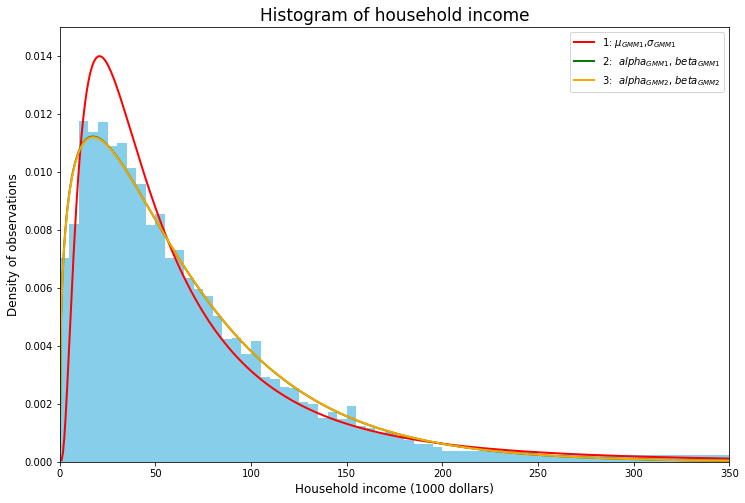

In [54]:
plt.figure(figsize=(12, 8))

weights = (1 / (inc.shape[0]*5)) * np.ones_like(inc)

weights[(len(weights) - (hist[-2] + hist[-1]) +1) : (len(weights) - hist[-1] +1)] =\
weights[(len(weights) - (hist[-2] + hist[-1]) +1) : (len(weights) - hist[-1] +1)]/10

weights[(len(weights) - hist[-1] +1) :] =\
weights[(len(weights) - hist[-1] +1) :]/20

inc_sort = np.sort(inc)

x_scale = np.array([0, 50000, 100000, 150000, 200000, 250000, 300000, 350000])

plt.hist(inc_sort, bins=edges, weights=weights, color="skyblue")

# Plot the estimated GMM PDF for log-normal
dist_pts = np.linspace(1, 350, 500)
plt.plot(dist_pts*1000, log_norm_pdf(dist_pts, mu_GMM1, sig_GMM1),
         linewidth=2, color='red', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')

# Plot the estimated GMM PDF for gamma(original)
dist_pts = np.linspace(1, 350000, 500)
plt.plot(dist_pts, gamma_dist(dist_pts, alpha_GMM1, beta_GMM1)*1000,
         linewidth=2, color='green', label='2: $\ alpha_{GMM1}$,$\ beta_{GMM1}$')

# Plot the estimated GMM PDF for gamma(two step)
dist_pts = np.linspace(1, 350000, 500)
plt.plot(dist_pts, gamma_dist(dist_pts, alpha_GMM2, beta_GMM2)*1000,
         linewidth=2, color='orange', label='3: $\ alpha_{GMM2}$,$\ beta_{GMM2}$')

plt.title('Histogram of household income', fontsize=17)
plt.xlabel(r'Household income (1000 dollars)', fontsize=12)
plt.xticks(x_scale, (x_scale/1000).astype(int))
plt.ylabel(r'Density of observations', fontsize=12)
plt.xlim([0, 350000])
plt.ylim([0, 0.015])
plt.legend(loc='upper right')

Q2

(a)Load data.

In [55]:
macro = pd.read_csv("data/MacroSeries.txt", header=None)
macro.columns = ["c_t", "k_t", "w_t", "r_t"]
macro.head()

,c_t,k_t,w_t,r_t
0,1.067109e+07,8.040697e+06,1.059438e+07,0.954120
1,1.169487e+07,7.595072e+06,1.161079e+07,1.107009
2,9.292394e+06,8.323735e+06,9.225588e+06,0.802596
3,7.913165e+06,6.613792e+06,7.856274e+06,0.860176
4,8.140994e+06,5.632136e+06,8.082466e+06,1.039183


We define error vector function and criterion function as below. The moments conditions are equations (6)-(9). We want these moments to be zero, thus weighted sum of these moments is the criterion value which we will minimize.

we can derive $z$ using equation(4) as below.

$$ r_t-\alpha e^{z_t}k_{t}^{\alpha-1} = 0 $$ 
$$ e^{z_t} = \frac{r_t}{\alpha k_{t}^{\alpha-1}} $$ 
$$ z_t = ln(\frac{r_t}{\alpha k_{t}^{\alpha-1}}) $$

In [56]:
init_alpha= 0.5

z_t = np.log(macro.r_t/(init_alpha*(macro.k_t**(init_alpha-1))))

init_mu = np.mean(z_t)
init_sigma = np.sqrt(np.var(z_t))

init_p = 0.1

In [57]:
mom_1 = np.zeros(len(z_t))
for i in range(len(z_t)-1):
    mom_1[i] = z_t[i + 1] - init_p*z_t[i] - (1-init_p)*init_mu
np.mean(mom_1)

0.0002470653254995447

In [58]:
def err_vec(c, k, w, r, alpha, mu, sigma, p, simple):
    '''
    
    '''
    beta = 0.99
    z = np.log(r/(alpha*(k**(alpha-1))))
    
    mom_1 = np.zeros(len(z))
    mom_2 = np.zeros(len(z))
    mom_3 = np.zeros(len(z))
    mom_4 = np.zeros(len(z))
    for i in range(len(z)-1):
        mom_1[i] = z[i + 1] - p*z[i] - (1-p)*mu
        mom_2[i] = (z[i + 1] - p*z[i] - (1-p)*mu)*z[i]
        mom_3[i] = beta*alpha*np.exp(z[i+1])*((k[i+1]**(alpha-1)))*(c[i]/c[i+1])-1
        mom_4[i] = (beta*alpha*np.exp(z[i+1])*((k[i+1]**(alpha-1)))*(c[i]/c[i+1])-1)*w[i]
        
    mom_1 = np.mean(mom_1)
    mom_2 = np.mean(mom_2)
    mom_3 = np.mean(mom_3)
    mom_4 = np.mean(mom_4)
    err_vec = np.array([mom_1, mom_2, mom_3, mom_4])
    
    return err_vec

def criterion(params, *args):
    '''
   
    '''
    alpha, mu, sigma, p = params
    c, k, r, w, W = args
    err = err_vec(c, k, r, w, alpha, mu, sigma, p, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

Below we perform GMM estimation. We set initial alpha = 0.5, p = 0(half of the range) and mu and sigma as mean and sd of z derived from initial alpha.

The resulting parameter are alpha = 0.99, mu = 8.61, sigma = 0.126, p = 0. 
The minimized criterion value is 213320864509152.

In [59]:
init_alpha= 0.5

z_t = np.log(macro.r_t/(init_alpha*(macro.k_t**(init_alpha-1))))

init_mu = np.mean(z_t)
init_sigma = np.sqrt(np.var(z_t))

init_p = 0

c = macro.c_t
k = macro.k_t
r = macro.r_t
w = macro.w_t

params_init = np.array([init_alpha, init_mu, init_sigma, init_p])
W_hat = np.eye(4)
gmm_args = (c, k, r, w, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       tol=1e-14, method='L-BFGS-B',
                       bounds=((1e-10, 1-(1e-10)), (1e-10, None),(1e-10, None), (-1+1e-10, 1-1e-10)))
alpha_GMM3, mu_GMM3, sigma_GMM3, p_GMM3 = results.x
print('alpha_GMM3=', alpha_GMM3, ' mu_GMM3=', mu_GMM3, ' sigma_GMM3=', sigma_GMM3, ' p_GMM3=', p_GMM3)
results

alpha_GMM3= 0.999999989508843  mu_GMM3= 8.607220363712564  sigma_GMM3= 0.12606680690988187  p_GMM3= 0.0


      fun: 213320864501952.47
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 120
      nit: 3
   status: 0
  success: True
        x: array([0.99999999, 8.60722036, 0.12606681, 0.        ])